## Popularity–Sentiment Quadrant Analysis (Portfolio View)

Classify products into four segments using `loves_count` (popularity) and `avg_sentiment` (customer perception).
This cell computes median thresholds, assigns segments, visualizes the portfolio, and prints top products per quadrant.

In [ ]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import os

# If product_sent already exists (from earlier runs), keep it
if 'product_sent' in globals():
    print('`product_sent` already available in notebook globals')
else:
    # Load merged reviews
    merged_path = 'merged_clean.csv'
    if not os.path.exists(merged_path):
        raise FileNotFoundError(f"Cannot compute product-level sentiment: {merged_path} not found")

    merged = pd.read_csv(merged_path, engine='python', on_bad_lines='skip', low_memory=False)
    # Keep only needed cols
    cols_needed = ['product_id', 'product_name_product', 'secondary_category', 'review_text']
    present = [c for c in cols_needed if c in merged.columns]
    if 'review_text' not in merged.columns:
        raise KeyError('merged_clean.csv must contain `review_text` to compute sentiment')

    merged = merged[['product_id', 'review_text']].dropna(subset=['review_text'])
    print('Reviews loaded for sentiment:', len(merged))

    sid = SentimentIntensityAnalyzer()
    merged['sentiment_score'] = merged['review_text'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

    def label_sentiment(score):
        if score > 0.05:
            return 'Positive'
        elif score < -0.05:
            return 'Negative'
        else:
            return 'Neutral'

    merged['sentiment_label'] = merged['sentiment_score'].apply(label_sentiment)

    # Aggregate per product
    product_sent = (
        merged
        .groupby('product_id')
        .agg(
            avg_sentiment=('sentiment_score', 'mean'),
            median_sentiment=('sentiment_score', 'median'),
            positive_share=('sentiment_label', lambda x: (x == 'Positive').mean() * 100),
            sentiment_review_count=('sentiment_score', 'count')
        )
        .reset_index()
    )

    product_sent['avg_sentiment'] = product_sent['avg_sentiment'].round(3)
    product_sent['positive_share'] = product_sent['positive_share'].round(1)

    print('Computed product_sent (rows):', len(product_sent))
    # Optionally save for downstream runs
    try:
        product_sent.to_csv('product_sent.csv', index=False)
        print('Saved product_sent.csv')
    except Exception:
        pass

    # make available in globals
    globals()['product_sent'] = product_sent
    display(product_sent.head())

In [7]:
import pandas as pd
import os

def build_product_level_df(
    products_df: pd.DataFrame,
    sentiment_df: pd.DataFrame,
    join_type: str = "left"
) -> pd.DataFrame:
    """
    Build a clean product-level dataframe by merging product metadata
    with aggregated sentiment metrics.
    """

    # --- Basic validation ---
    if "product_id" not in products_df.columns:
        raise KeyError("products_df must contain 'product_id'")
    if "product_id" not in sentiment_df.columns:
        raise KeyError("sentiment_df must contain 'product_id'")
    if "avg_sentiment" not in sentiment_df.columns:
        raise KeyError("sentiment_df must contain 'avg_sentiment'")

    # --- Merge ---
    df = products_df.merge(
        sentiment_df,
        on="product_id",
        how=join_type,
        validate="one_to_one"
    )

    # --- Coerce numeric columns safely ---
    numeric_cols = [
        "loves_count",
        "reviews",
        "rating",
        "price_usd",
        "avg_sentiment",
        "median_sentiment",
        "positive_share",
        "negative_share",
        "sentiment_review_count"
    ]

    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # --- Coverage reporting (VERY IMPORTANT) ---
    coverage = df["avg_sentiment"].notna().mean() * 100
    print(f"Sentiment coverage: {coverage:.1f}% of products")

    print(f"Final product-level shape: {df.shape}")

    return df


# --- Load products table ---
products_path = os.path.join("archive", "product_info.csv")
if not os.path.exists(products_path):
    raise FileNotFoundError(f"Products file not found: {products_path}")
products = pd.read_csv(products_path, low_memory=False)
print(f"Loaded products (rows={len(products)})")

# --- Locate product_sent ---
if 'product_sent' in globals():
    product_sent_local = product_sent
    print("Using existing `product_sent` from notebook globals")
else:
    # Try common filenames
    candidates = [
        "product_sent.csv",
        "product_sent_per_product.csv",
        "product_sentiment.csv",
        "product_sent_aggregated.csv"
    ]
    product_sent_local = None
    for fn in candidates:
        if os.path.exists(fn):
            product_sent_local = pd.read_csv(fn)
            print(f"Loaded product_sent from {fn}")
            break
    if product_sent_local is None:
        # create empty sentiment dataframe with required columns so left-join succeeds
        product_sent_local = pd.DataFrame(columns=["product_id", "avg_sentiment"])
        print("No product_sent found — created empty sentiment dataframe (avg_sentiment NaN)")

# Ensure required columns exist in sentiment df (create if missing but with NaNs)
if 'product_id' not in product_sent_local.columns:
    product_sent_local['product_id'] = pd.Series(dtype=object)
if 'avg_sentiment' not in product_sent_local.columns:
    product_sent_local['avg_sentiment'] = pd.Series(dtype=float)

# --- Build merged product-level df ---
df = build_product_level_df(
    products_df=products,
    sentiment_df=product_sent_local,
    join_type='left'
)

# --- Sanity check display ---
display_cols = []
for cname in ['product_name', 'product_name_product', 'name']:
    if cname in df.columns:
        display_cols.append(cname)
        break
for cname in ['loves_count', 'avg_sentiment']:
    if cname in df.columns:
        display_cols.append(cname)

if display_cols:
    print(df[display_cols].head())
else:
    print('Built `df` but display columns not found; available columns:', df.columns.tolist())

Loaded products (rows=8494)
No product_sent found — created empty sentiment dataframe (avg_sentiment NaN)
Sentiment coverage: 0.0% of products
Final product-level shape: (8494, 28)
                product_name  loves_count  avg_sentiment
0    Fragrance Discovery Set         6320            NaN
1    La Habana Eau de Parfum         3827            NaN
2  Rainbow Bar Eau de Parfum         3253            NaN
3       Kasbah Eau de Parfum         3018            NaN
4  Purple Haze Eau de Parfum         2691            NaN


Series([], Name: count, dtype: int64)


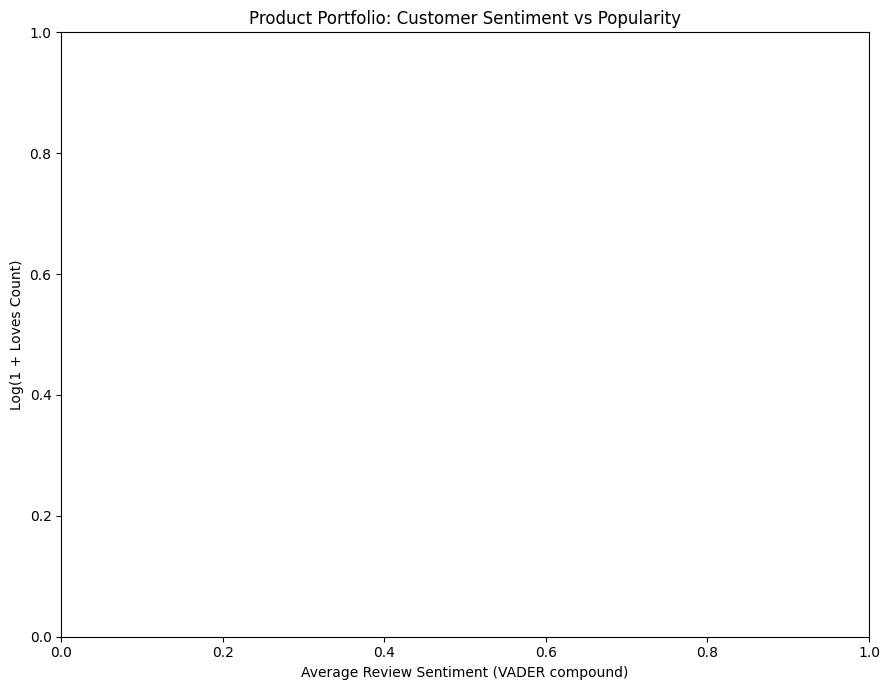

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


# --- Ensure correct columns exist ---
required = ["product_id", "product_name", "loves_count", "avg_sentiment"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise KeyError(f"Your df is not product-level / missing columns: {missing}\n"
                   f"Tip: df should be products.merge(product_sent, ...) not merged_clean.csv")

# --- Prep (filter only what’s needed for segmentation) ---
df_q = df.dropna(subset=["loves_count", "avg_sentiment"]).copy()

# Use log_loves for better behavior (skewed distribution)
df_q["log_loves"] = np.log1p(df_q["loves_count"])

pop_thr = df_q["log_loves"].median()
sent_thr = df_q["avg_sentiment"].median()

df_q["popularity_level"] = np.where(df_q["log_loves"] >= pop_thr, "High", "Low")
df_q["sentiment_level"] = np.where(df_q["avg_sentiment"] >= sent_thr, "High", "Low")
df_q["segment"] = df_q["popularity_level"] + " Popularity / " + df_q["sentiment_level"] + " Sentiment"

print(df_q["segment"].value_counts())



# --- Plot ---
plt.figure(figsize=(9,7))
sns.scatterplot(data=df_q, x="avg_sentiment", y="log_loves", hue="segment", alpha=0.4)
plt.axvline(sent_thr, ls="--", c="grey")
plt.axhline(pop_thr, ls="--", c="grey")
plt.title("Product Portfolio: Customer Sentiment vs Popularity")
plt.xlabel("Average Review Sentiment (VADER compound)")
plt.ylabel("Log(1 + Loves Count)")
plt.tight_layout()
plt.show()

# --- Top products per segment (fix column names) ---
count_col = "sentiment_review_count" if "sentiment_review_count" in df_q.columns else None

cols = ["product_name", "product_id", "loves_count", "avg_sentiment"]
if "brand_name" in df_q.columns: cols.insert(1, "brand_name")
if "secondary_category" in df_q.columns: cols.insert(2, "secondary_category")
if count_col: cols.append(count_col)

top_by_segment = (
    df_q.sort_values("loves_count", ascending=False)
        .groupby("segment")
        .head(5)
)

for seg, grp in top_by_segment.groupby("segment"):
    print(f"\nTop products — {seg}:")
    display(grp[cols])
